In [61]:
%load_ext autoreload
%autoreload 2

from charting import create_performance_chart
from llm_service import litellm_service, custom_llm_service
from utils import get_llm_answers, get_llm_stats, load_all_llm_answers_from_json, model_clean
from auto_eval import (
    create_all_llm_eval_messages, 
    extract_all_scores, 
    create_auto_eval_json, 
    get_llm_eval_responses, 
    score_multiple_choice_answers,
    validation_func,
)
from multiple_choice import construct_multiple_choice_question

from datetime import datetime
import pandas as pd
import json

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Variables

In [ ]:
answer_models = [
    "gpt-4-turbo-preview", 
    "gpt-4o",
    "meta.llama3-70b-instruct-v1:0", 
    "mistral/mistral-large-latest", 
    "mistral/open-mixtral-8x22b", 
    "claude-3-opus-20240229", 
    "vertex_ai/gemini-1.5-pro", 
    "vertex_ai/gemini-1.0-pro",
    "command-r", 
]

answer_rounds = 10 # Number of rounds of questions to ask each model
answer_hyperparams = {
    'batch_size': 10, # Max number of questions to send to a model at once (10 is sensible)
    'temperature': 0, # 0 is default and the most deterministic
    'max_tokens': 2048, # 2048 works for most models, but may have to be reduced for some models
    'num_retries': 5, # Number of times to retry a question if it fails
}

auto_eval_rounds = 1 # Number of rounds of auto evaluation to run to then average the scores
auto_eval_model = "gpt-4o"
auto_eval_hyperparams= {
    'temperature': 0,
    'max_tokens': 2048,
    'batch_size': 30,
}

multiple_choice_questions = True
benchmark_name = 'Benchmark' if not multiple_choice_questions else 'Multi-Benchmark'
date_now = datetime.now().strftime('%Y-%m-%d') #'2024-06-10'
answers_save_path = f"./{date_now}-{benchmark_name}/llm_outputs"
auto_eval_save_path = f"./{date_now}-{benchmark_name}/auto_eval_outputs"
stats_save_path = f"./{date_now}-{benchmark_name}/tables_and_charts"


execution_steps = [
    "get_llm_answers",
    "auto_evaluate_answers",
    "generate_statistics", 
]

## Run Benchmark

In [ ]:
def calc_incomplete_llm_answers(all_llm_answers, auto_eval_save_path, sub_eval_folders, date_now):
    all_llm_evals = load_all_llm_answers_from_json(auto_eval_save_path,
        prefix_replace='auto_eval-', sub_folders=sub_eval_folders)
    skip_evals = set(all_llm_evals.keys() & set(all_llm_answers.keys()))
    print(f'Skipping existing LLM evals (in {date_now} folder):', skip_evals)
    incomplete_llm_answers = {model: value for model, value in all_llm_answers.items() 
                               if model_clean(model) not in skip_evals}
    return incomplete_llm_answers

In [ ]:
# Load in benchmark questions
if multiple_choice_questions:
    benchmark_questions = json.load(open('linguistic_benchmark_multi_choice.json', 'r'))
    sub_eval_folders = ['']
    def answer_validation_func(x):
        return validation_func(x, json_key='ANSWER', list_of_values=['A', 'B', 'C', 'D'])
else:
    benchmark_questions = json.load(open('linguistic_benchmark.json', 'r'))
    sub_eval_folders = [f'/round_{r+1}' for r in range(auto_eval_rounds)]
sub_answer_folders = [f'/round_{r+1}' for r in range(answer_rounds)]


if "get_llm_answers" in execution_steps:
    print('1. GETTING LLM ANSWERS')
    # Load in any existing answers and evals to avoid overwriting them
    for n in range(answer_rounds):
        print(f'\n----- Round: {n+1} of {answer_rounds} -----')
        answer_save_path_round = f"{answers_save_path}/round_{n+1}"
        all_llm_answers = load_all_llm_answers_from_json(answer_save_path_round,
            prefix_replace='final_answers-')
        print(f'Skipping existing LLM answers (in {date_now} folder):', list(all_llm_answers.keys()))
        answer_models_run = [model for model in answer_models 
                            if model_clean(model) not in all_llm_answers.keys()]
        if multiple_choice_questions:
            for q in benchmark_questions:
                prompt, correct_letter = construct_multiple_choice_question(q)
                q.update({'multi_choice_question': prompt, 'correct_letter': correct_letter})
        all_llm_answers = await get_llm_answers(
            litellm_service(),
            benchmark_questions,
            answer_models_run,
            answer_hyperparams,
            answer_save_path_round,
            multiple_choice_questions,
            validation_func=answer_validation_func if multiple_choice_questions else lambda x: True
        )
    print('-- DONE ANSWERS --\n')


if "auto_evaluate_answers" in execution_steps:
    print('2. AUTO EVALUATING ANSWERS')
    all_llm_answers = load_all_llm_answers_from_json(answers_save_path,
        prefix_replace='final_answers-', sub_folders=sub_answer_folders)
    if multiple_choice_questions:
        incomplete_llm_answers = calc_incomplete_llm_answers(all_llm_answers, auto_eval_save_path,
                                                             sub_eval_folders, date_now)
        all_llm_evals = score_multiple_choice_answers(incomplete_llm_answers, auto_eval_save_path)
    else:
        all_llm_eval_messages = create_all_llm_eval_messages(all_llm_answers, benchmark_questions)
        for n in range(auto_eval_rounds):
            print(f'- Round: {n+1} of {auto_eval_rounds} -')
            incomplete_llm_answers = calc_incomplete_llm_answers(all_llm_eval_messages, auto_eval_save_path,
                                                                 [f'/round_{n+1}'], date_now)
            all_llm_eval_responses = await get_llm_eval_responses(
                custom_llm_service(), 
                incomplete_llm_answers,
                model=auto_eval_model, 
                hyperparams=auto_eval_hyperparams,
                validation_func=lambda x: validation_func(x, json_key='score', 
                    list_of_values=[0, 20, 40, 60, 80, 100])
            )
            all_llm_scores = extract_all_scores(all_llm_eval_responses)
            auto_eval_save_path_n = f"{auto_eval_save_path}/round_{n+1}"
            all_auto_results = create_auto_eval_json(
                all_llm_scores, 
                all_llm_eval_responses, 
                all_llm_answers, 
                benchmark_questions, 
                auto_eval_save_path_n
            )
    print('-- DONE AUTO EVAL --\n')


if "generate_statistics" in execution_steps:
    print('3. GENERATING STATISTICS')
    all_llm_evals = load_all_llm_answers_from_json(
        auto_eval_save_path, 
        prefix_replace='auto_eval-',
        sub_folders=sub_eval_folders,
    )
    stats_df = get_llm_stats(all_llm_evals, stats_save_path, bootstrap_n=10000)
    if multiple_choice_questions:
        for model, evals_df in all_llm_evals.items():
            #evals_df['invalid_answer_letter'] = evals_df.apply(lambda x: x['json_answer_letter'] not in ['A', 'B', 'C', 'D'], axis=1)
            incorrect_letter_count = evals_df['invalid_answer_letter'].sum()
            print(model, incorrect_letter_count)
            stats_df.loc[model, 'invalid_outputs'] = incorrect_letter_count

    display(stats_df)
    barplot, plt = create_performance_chart(stats_df.reset_index())
    barplot.figure.savefig(f"{stats_save_path}/performance_chart.png")
    plt.show()
    print('-- DONE STATS --\n')

In [ ]:
answers = all_llm_evals['gpt-4-turbo-preview'][['question', 'model_answer', 'json_answer', 'correct_letter', 'score']]
for row in answers.to_dict('records'):
    print('--------------')
    print('\nQuestion\n', row['question'])
    print('\nModel Answer\n', row['model_answer'])
    print('\nJson Answer\n', row['json_answer'])
    print('\nCorrect Letter\n', row['correct_letter'])    
    print('\nScore\n', row['score'])

# Inspect Auto Eval Consistancy

In [ ]:
all_llm_evals = load_all_llm_answers_from_json(
    auto_eval_save_path, 
    prefix_replace='auto_eval-',
    sub_folders=sub_eval_folders,
)
models = list(all_llm_evals.keys())


model = models[3]
print(f"Model: {model}")
auto_eval_agg = all_llm_evals[model].set_index('level_0').groupby('index').agg({'score': ['mean', 'min', 'max']})
auto_eval_agg.index.name = 'Question #'
auto_eval_agg

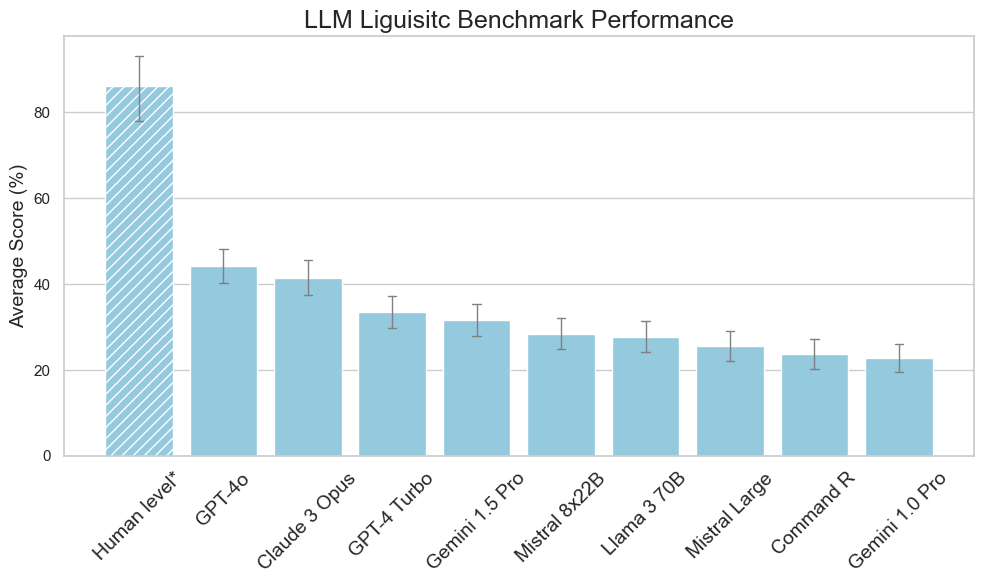

In [65]:
# tables_folder = "2024-06-12-Multi-Benchmark (temp=1)/tables_and_charts"
# stats_df = pd.read_csv(f"{tables_folder}/final_stats.csv", index_col=0)
# barplot, plt = create_performance_chart(stats_df.reset_index())
# barplot.figure.savefig(f"{tables_folder}/performance_chart.png")